In [0]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time #helper libraries

Using TensorFlow backend.


**WHY USE LSTM? Is it good to predict re-occuring data?I didn't get great results from the 1st notebook and decided to try to predict stock price movements by giving in stock price movements instead of just simple stock prices as input**


**In this notebook I normalized only the closing prices and then broke it into train and test datasets. I just kept a simple lookback window to give all similar data same movement(movement is just giving the data points the same kind of normalization) and put them in price points as input**



In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
link = 'https://drive.google.com/open?id=1y394o-wiPqYPaWzVYTPRr8xpE_aM9621'

In [0]:
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

1y394o-wiPqYPaWzVYTPRr8xpE_aM9621


In [0]:
import pandas as pd
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('AMZN.csv')  
df3 = pd.read_csv('AMZN.csv')
# Dataset is now stored in a Pandas Dataframe

W0812 17:46:22.876577 140683407243136 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0 or google-auth
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import Lock

In [0]:
#VANILLA LSTM NETWORK CREATED:

In [0]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time #helper libraries

In [0]:
df3 = df3.dropna(axis = "columns")

In [0]:
df3.head()

,Date,Open,High,Low,Adj Close,Volume,Close
0,1/4/2010,136.250000,136.610001,133.139999,133.899994,7599900,133.899994
1,1/5/2010,133.429993,135.479996,131.809998,134.690002,8851900,134.690002
2,1/6/2010,134.600006,134.729996,131.649994,132.250000,7178800,132.250000
3,1/7/2010,132.009995,132.320007,128.800003,130.000000,11030200,130.000000
4,1/8/2010,130.559998,133.679993,129.029999,133.520004,9830500,133.520004


In [0]:
#working with a conventional OHCLV dataset

In [0]:
import numpy as np

In [0]:
#FOCUS ON PREDICTING CLOSING PRICES AS BEFORE

In [0]:
df_close = df3['Close']

In [0]:
df_close.shape

(2265,)

In [0]:
#Reshaping it
df_close = df_close.values.reshape(2265,1)

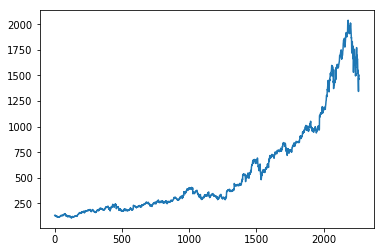

In [0]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

#Ploting it
plt.plot(df_close)
plt.show()

scaler = MinMaxScaler(feature_range=(0, 1))
df_close = scaler.fit_transform(df_close)


In [0]:
train_size = int(len(df_close) * 0.80)
test_size = len(df_close) - train_size
train, test = df_close[0:train_size,:], df_close[train_size:len(df_close),:]
print(len(train), len(test))

1812 453


**Normalize the values such that prices are reduced to normalized values and I can predict stock movement instead of actual prices**

In [0]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1): #keep only similar value data if a data point is too far of the last one jump to the next value
	dataX, dataY = [], []       #put this in data x
	for i in range(len(dataset)-look_back-1): #let dataY have only output values
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [0]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [0]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [0]:
#Step 2 Build Model
model = Sequential()

model.add(LSTM(
    input_dim=1,
    output_dim=50,
    return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
    100,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(
    output_dim=1))
model.add(Activation('relu'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])
print ('compilation time : ', time.time() - start)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 1), units=50)`
  


compilation time :  0.031675100326538086


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
  from ipykernel import kernelapp as app


In [0]:
model.fit(
    trainX,
    trainY,
    batch_size=128,
    nb_epoch=80,
    validation_split=0.05)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1719 samples, validate on 91 samples
Epoch 1/80
1719/1719 [==============================] - 2s 932us/step - loss: 0.0118 - mean_absolute_error: 0.0760 - val_loss: 0.0522 - val_mean_absolute_error: 0.2278
Epoch 2/80
1719/1719 [==============================] - 0s 91us/step - loss: 0.0066 - mean_absolute_error: 0.0630 - val_loss: 0.0383 - val_mean_absolute_error: 0.1950
Epoch 3/80
1719/1719 [==============================] - 0s 86us/step - loss: 0.0051 - mean_absolute_error: 0.0564 - val_loss: 0.0274 - val_mean_absolute_error: 0.1649
Epoch 4/80
1719/1719 [==============================] - 0s 86us/step - loss: 0.0033 - mean_absolute_error: 0.0448 - val_loss: 0.0111 - val_mean_absolute_error: 0.1050
Epoch 5/80
1719/1719 [==============================] - 0s 86us/step - loss: 0.0016 - mean_absolute_error: 0.0317 - val_loss: 0.0045 - val_mean_absolute_error: 0.0670
Epoch 6/80
1719/1719 [==============================] - 0s 87us/step - loss: 5.8823e-04 - mean_absolute_error: 0.0186 

**is it overtrained? lets run again with 40 epochs**

In [0]:
model.fit(
    trainX,
    trainY,
    batch_size=128,
    nb_epoch=40,
    validation_split=0.05)

Train on 1719 samples, validate on 91 samples
Epoch 1/40
1719/1719 [==============================] - 0s 102us/step - loss: 1.4395e-04 - mean_absolute_error: 0.0088 - val_loss: 7.2878e-05 - val_mean_absolute_error: 0.0075
Epoch 2/40
 128/1719 [=>............................] - ETA: 0s - loss: 9.1589e-05 - mean_absolute_error: 0.0062

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


1719/1719 [==============================] - 0s 95us/step - loss: 1.1378e-04 - mean_absolute_error: 0.0077 - val_loss: 7.1421e-05 - val_mean_absolute_error: 0.0073
Epoch 3/40
1719/1719 [==============================] - 0s 89us/step - loss: 1.3333e-04 - mean_absolute_error: 0.0084 - val_loss: 3.9828e-05 - val_mean_absolute_error: 0.0050
Epoch 4/40
1719/1719 [==============================] - 0s 93us/step - loss: 1.2639e-04 - mean_absolute_error: 0.0082 - val_loss: 3.1434e-05 - val_mean_absolute_error: 0.0042
Epoch 5/40
1719/1719 [==============================] - 0s 93us/step - loss: 1.2105e-04 - mean_absolute_error: 0.0080 - val_loss: 6.5291e-05 - val_mean_absolute_error: 0.0070
Epoch 6/40
1719/1719 [==============================] - 0s 88us/step - loss: 1.3959e-04 - mean_absolute_error: 0.0085 - val_loss: 4.1084e-04 - val_mean_absolute_error: 0.0196
Epoch 7/40
1719/1719 [==============================] - 0s 87us/step - loss: 1.2085e-04 - mean_absolute_error: 0.0080 - val_loss: 3.6565

**Final Predictions**

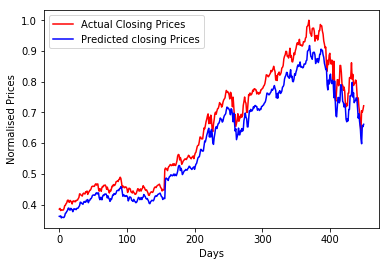

In [0]:
import matplotlib.pyplot as plt
predicted_stateful = model.predict(testX)
plt.plot(testY, color = 'red',label = 'Actual Closing Prices')
plt.plot(predicted_stateful.flatten(), color = 'blue', label  = 'Predicted closing Prices')
plt.xlabel('Days')
plt.ylabel('Normalised Prices')
plt.legend(loc='best')
plt.show()

**So LSTM  works great to predict Closing Prices when we normalize the prices and predict the stock Price movement.**

In [0]:
mae = model.evaluate(trainX,
    trainY,
    batch_size=128,verbose=1)

1810/1810 [==============================] - 0s 28us/step


[0.00017531904821587696, 0.01169782763974772]

**Seems like using LSTM to predict stock price movement gives much better prediction resullts!!**

**Will work more on this in the next notebook..**